# Creating a Working Pokédex - Image Classification With Neural Networks

## Summary

Creating a real-world Pokédex that can scan an image of a Pokémon and tell you its type (anything from Water to Flying) seems like a problem built for an image classification neural network.

In addition to collecting enough images that spread equally across the generations, types, and individual Pokémon, there's the challenge of typing itself: Pokémon don’t necessarily resemble the others in their type class but might with other classes. They could also have primary and secondary typing.

To begin, I preprocessed the data (collected from Bulbapedia, PokemonDB, and two Kaggle datasets – "7,000 Labeled Pokemon" by Lance Zhang and "Pokemon Generation One" by Harshit Dwivedi. With over 15,000 images from the Kaggle sets and only 2,000 from the sites, the image collection is disproportionately populated by Generation 1 Pokémon. I omitted secondary typing, focusing on the most common 9 type classes instead of the full 18. In the end, I had nearly 10,000 images to model on.

I began with a simple convolutional network with two hidden layers and got 90% accuracy on the train set but only 50% on the test. Each subsequent model was tuned against overfitting with increased regularization, new optimizers, or more layers. I first used the Adam optimizer and briefly tried SGD. Altering the learning rate with SGD kept breaking the kernel in a way I couldn't solve. 

Ultimately the best model was the first one with only two convolutional layers and two dense layers, achieving a little over 50% accuracy on the test.

This could be because there weren't enough images of each individual Pokémon, each type class, or because it was correctly labeled for secondary type but incorrectly for primary.

I recommend the Pokémon Company more often matches their Pokémon designs to typing to help game players (mostly kids) learn the world quickly and that they more prominently feature newer Pokémon in the show so we have more images for the model. Next steps would be to collect more images and a greater diversity of them. Also, bringing in all the types and secondary typing is critical to the next Pokédex.

## Add Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.preprocessing import image

import splitfolders
import os
import shutil
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout 
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping

import warnings 
warnings.filterwarnings("ignore")

## Read In Data

After initial imports, we'll bring in the previously made CSVs for Pokémon image name, name, address, and typing. Review the web_surfacing notebooks for this.

The scraped data includes about 2000 images, seen in the following df dataframe.

In [2]:
# pokedex
df1 = pd.read_csv("data/pokedex.csv", index_col=0)
df1["image_address"] = df1["image"]
df1 = df1.drop(columns = "image")

# pokedex2
df2 = pd.read_csv("data/pokedex2.csv", index_col=0)

# concat dataframes
df = pd.concat([df1, df2])
df

,dex_no,name,type1,type2,image_name,image_address
0,1.0,Bulbasaur,Grass,Poison,pokedex_bulbasaur.jpg,https://img.pokemondb.net/sprites/home/normal/...
1,2.0,Ivysaur,Grass,Poison,pokedex_ivysaur.jpg,https://img.pokemondb.net/sprites/home/normal/...
2,3.0,Venusaur,Grass,Poison,pokedex_venusaur.jpg,https://img.pokemondb.net/sprites/home/normal/...
3,4.0,Charmander,Fire,NaN,pokedex_charmander.jpg,https://img.pokemondb.net/sprites/home/normal/...
4,5.0,Charmeleon,Fire,NaN,pokedex_charmeleon.jpg,https://img.pokemondb.net/sprites/home/normal/...
...,...,...,...,...,...,...
1150,NaN,Iron_Valiant,Fairy,Fighting,pokedex2_Iron_Valiant.png,archives.bulbagarden.net/media/upload/thumb/2/...
1151,NaN,Koraidon,Fighting,Dragon,pokedex2_Koraidon.png,archives.bulbagarden.net/media/upload/thumb/a/...
1152,NaN,Miraidon,Electric,Dragon,pokedex2_Miraidon.png,archives.bulbagarden.net/media/upload/thumb/1/...
1153,NaN,Walking_Wake,Water,Dragon,pokedex2_Walking_Wake.png,archives.bulbagarden.net/media/upload/thumb/b/...


We have more images in total, thanks to the Kaggle datasets mentioned above. By the end we have about 20,000 images but we won't be using all of them.

In [3]:
# make new dataframe out of all the images listed in the images folder
df_imagesonly = pd.DataFrame(os.listdir("data/images"))
df_imagesonly.columns = ["image_name"]
df_imagesonly["name"] = df_imagesonly["image_name"]
df_imagesonly["name"] = df_imagesonly["name"].str.replace(".png", "").str.replace(".jpg", "").str.replace(".svg", "")
df_imagesonly["name"] = df_imagesonly["name"].str.replace("\d+", "")
df_imagesonly["name"] = df_imagesonly["name"].str.capitalize()
df_imagesonly["name"] = df_imagesonly["name"].str.split("_").apply(lambda x: x[1])
df_imagesonly["name"] = df_imagesonly["name"].str.title()

In [4]:
# create new dataframe for just names and types
names_and_types = df[["name", "type1"]]

# combine with df_imagesonly
images_types = df_imagesonly.merge(names_and_types)
images_types

,image_name,name,type1
0,dataset_Dodrio33.jpg,Dodrio,Normal
1,dataset_Dodrio33.jpg,Dodrio,Normal
2,dataset_Dodrio27.jpg,Dodrio,Normal
3,dataset_Dodrio27.jpg,Dodrio,Normal
4,dataset_Dodrio26.jpg,Dodrio,Normal
...,...,...,...
19664,pokedex2_Ninetales-Alola.png,Ninetales-Alola,Ice
19665,pokedex_burmy.jpg,Burmy,Bug
19666,pokedex2_Raichu-Alola.png,Raichu-Alola,Electric
19667,pokedex2_Eiscue-Noice.png,Eiscue-Noice,Ice


## EDA

The majority of the images in our collection are for Generation 1 and the original 150 Pokémon, thanks to the Kaggle datasets. The rest include two images each for Generations 1-9, which includes over 1000 Pokémon. This dataset includes regional variant Pokémon for Alola and Galar, which typically have different typing from the original designs.

There is a pretty large range in the amount of images are in the dataset. From over 500 to only 1. Let's look at the most common Pokemon.

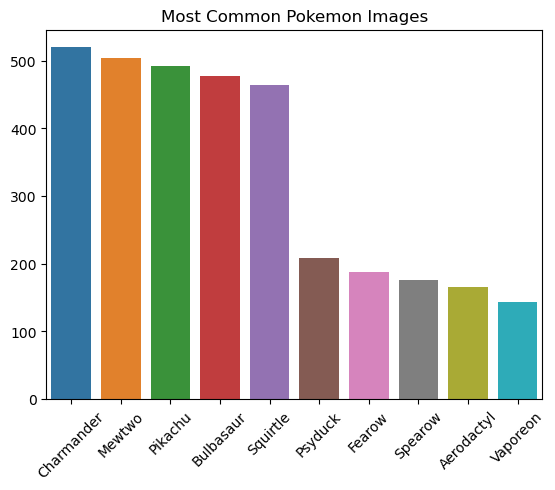

In [5]:
# graphing most common image counts
top_pokemon = dict(images_types["name"].value_counts().head(10))
pokemon_names = list(top_pokemon.keys())
pokemon_count = list(top_pokemon.values())
bar_plot = sns.barplot(x=pokemon_names, y=pokemon_count)
plt.xticks(rotation=45)
plt.title("Most Common Pokemon Images")
plt.show();

In [6]:
images_types["name"].value_counts().tail(10)

Basculin-Red       1
Goodra-Hisui       1
Aegislash          1
Indeedee           1
Rotom-Fan          1
Zacian-Hero        1
Cherrim-Sunny      1
Morpeko            1
Kyurem-White       1
Sandshrew-Alola    1
Name: name, dtype: int64

We have more photos of Charmander, Mewtwo, Pikachu, Bulbasaur, and Squirtle than the rest and some have only one image each.

The second thing we'll want to do is understand which types are represented amongst our images and how many of each kind there are.

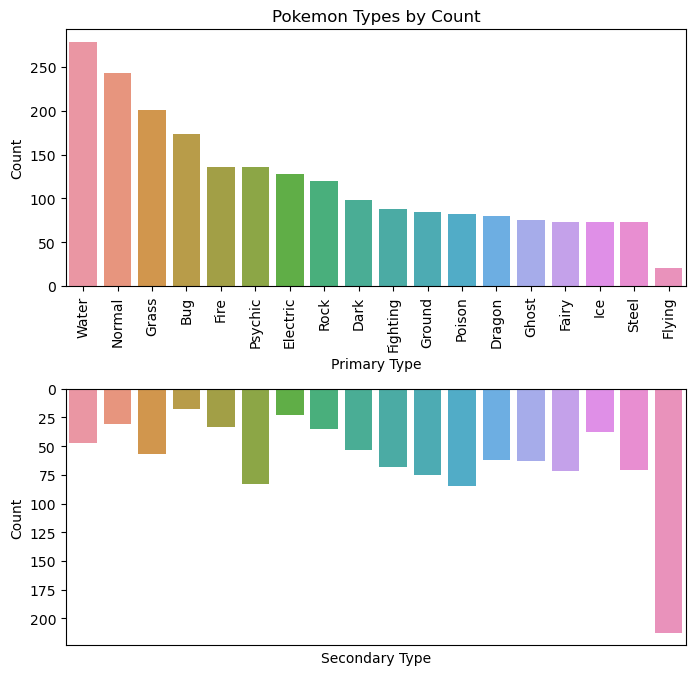

In [7]:
# create a dataframe with primary type counts
type1_counts = df["type1"].value_counts().reset_index()
type1_counts.columns = ["type", "type1count"]
type1_counts = type1_counts.set_index("type")

# create a dataframe with secondary type counts
type2_counts = df["type2"].value_counts().reset_index()
type2_counts.columns = ["type", "type2count"]
type2_counts = type2_counts.set_index("type")

# concatenate dataframes
type_counts_df = pd.concat([type1_counts, type2_counts], axis = 1)
type_counts_df = type_counts_df.reset_index()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# primary type graph
sns.barplot(x="type", y="type1count", data=type_counts_df, ax=ax1)
ax1.set_title('Pokemon Types by Count')
ax1.set_xlabel('Primary Type')
ax1.set_ylabel('Count')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

# secondary type graph
sns.barplot(x="type", y="type2count", data=type_counts_df, ax=ax2)
ax2.set_xlabel('Secondary Type')
ax2.set_ylabel('Count')
ax2.set_xticks([])

# flip the second plot, add space between graphs
ax2.invert_yaxis()
plt.subplots_adjust(hspace=0.4)

# show the plot
plt.show()

The vast majority of the Pokémon seem to be Water types, followed by Normal and Grass. This might skew our data, though intuitively it's more likely that the model misclassifies Bug and Grass for each other as they often are the same shape and color.

Flying, Steel, Ice, Fairy, and Ghost are the least populated types. But that could be because they're often the secondary types for Pokémon, which we're not including in modeling to make it simpler. We'll focus on the 10 most common types.

In [8]:
# cleaning
# remove rows that do not contain main types
main_types = ["Water", "Normal", "Grass", "Bug", "Fire", "Psychic", "Electric", "Rock", "Dark", "Fighting"]
images_types = images_types[images_types["type1"].isin(main_types)]
images_types

,image_name,name,type1
0,dataset_Dodrio33.jpg,Dodrio,Normal
1,dataset_Dodrio33.jpg,Dodrio,Normal
2,dataset_Dodrio27.jpg,Dodrio,Normal
3,dataset_Dodrio27.jpg,Dodrio,Normal
4,dataset_Dodrio26.jpg,Dodrio,Normal
...,...,...,...
19661,pokedex2_Rotom-Mow.png,Rotom-Mow,Electric
19662,pokedex2_Morpeko-Hangry.png,Morpeko-Hangry,Electric
19663,pokedex2_Rapidash-Galar.png,Rapidash-Galar,Psychic
19665,pokedex_burmy.jpg,Burmy,Bug


## Split Folders for Train-Test and By Class

Time to get modeling. We'll start by sorting images into train and test, making folders for both, creating classifier labels, and then moving the images into their proper type classifier folder within both the trian and test folders.

In [9]:
# create train-test-validation folders
splitfolders.ratio("data", output="train_test_folders", seed=1337, ratio=(.8, 0.2)) 

# add images to folders
train_list = []
for image in os.listdir("train_test_folders/train/images"):
    train_list.append(image)
    
test_list = []
for image in os.listdir("train_test_folders/val/images"):
    test_list.append(image)

    
# note in dataframe which folder image is in
train_df = images_types.loc[images_types.apply(lambda row: row["image_name"] in train_list, axis=1)]
test_df = images_types.loc[images_types.apply(lambda row: row["image_name"] in test_list, axis=1)]

train_df["split"] = "train"
test_df["split"] = "test"

pdList = [train_df, test_df]
df_tts = pd.concat(pdList)
df_tts = df_tts.drop_duplicates("image_name")
df_tts

Copying files: 10131 files [00:02, 4945.10 files/s]


,image_name,name,type1,split
4,dataset_Dodrio26.jpg,Dodrio,Normal,train
6,dataset_Dodrio32.jpg,Dodrio,Normal,train
8,dataset_Dodrio24.jpg,Dodrio,Normal,train
10,dataset_Dodrio30.jpg,Dodrio,Normal,train
12,dataset_Dodrio18.jpg,Dodrio,Normal,train
...,...,...,...,...
19647,pokedex2_Deoxys-Defense.png,Deoxys-Defense,Psychic,test
19649,pokedex2_Burmy-Sandy.png,Burmy-Sandy,Bug,test
19650,pokedex2_Lycanroc-Dusk.png,Lycanroc-Dusk,Rock,test
19651,pokedex2_Burmy-Trash.png,Burmy-Trash,Bug,test


In [10]:
# add class folders and organize images
train_dir = "train_test_folders/train/images"
test_dir = "train_test_folders/val/images"

for index, row in df_tts.iterrows():
    class_label = row["type1"]  
    filename = row["image_name"]  
    if class_label not in os.listdir(train_dir):
        os.mkdir(os.path.join(train_dir, class_label))
    if class_label not in os.listdir(test_dir):
        os.mkdir(os.path.join(test_dir, class_label))
    if row["split"] == "train":
        shutil.move(os.path.join(train_dir, filename), os.path.join(train_dir, class_label))
    elif row["split"] == "test":
        shutil.move(os.path.join(test_dir, filename), os.path.join(test_dir, class_label))

# Modeling

First we'll create the generators we'll run our CNN models on. Because Pokémon images are pretty simple in design with black outlines and 2-3 colors, a smaller image size will make our models run better and faster. We'll aslo includ the "rgb" color mode.

In [11]:
# create generators
train_path = "train_test_folders/train/images"
test_path = "train_test_folders/val/images"

data_gen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True, vertical_flip = True)

train_generator = data_gen.flow_from_directory(train_path, target_size = (32, 32), color_mode = "rgb", 
                                                    batch_size = 32, class_mode = "categorical")

test_generator = data_gen.flow_from_directory(test_path, target_size = (32, 32), color_mode = "rgb", 
                                                    batch_size = 32, class_mode = "categorical")

Found 6372 images belonging to 10 classes.
Found 1605 images belonging to 10 classes.


## Model 1

For Model 1, we're going to use a simple convolutional model set up with a kernel size of (3,3). We'll have two hidden layers between our input and output.

In [12]:
# set regulator, loss function, and Adam optimizer
reg = l2(3e-3)
cce = tf.keras.losses.CategoricalCrossentropy()
opt = keras.optimizers.Adam()

In [13]:
# build model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])
model_1 = model.fit(train_generator, verbose = 1, validation_data = test_generator, epochs=100)

Metal device set to: Apple M1 Pro
Epoch 1/100


2023-03-31 19:17:59.995721: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-31 19:17:59.995835: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-03-31 19:18:00.137781: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  1/200 [..............................] - ETA: 1:05 - loss: 2.2323 - accuracy: 0.2188

2023-03-31 19:18:00.284724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - ETA: 0s - loss: 2.0891 - accuracy: 0.2680

2023-03-31 19:18:16.817211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - 21s 103ms/step - loss: 2.0891 - accuracy: 0.2680 - val_loss: 1.9861 - val_accuracy: 0.3240
Epoch 2/100
200/200 [==============================] - 21s 103ms/step - loss: 1.9861 - accuracy: 0.2994 - val_loss: 1.9342 - val_accuracy: 0.3533
Epoch 3/100
200/200 [==============================] - 20s 102ms/step - loss: 1.8580 - accuracy: 0.3697 - val_loss: 1.7984 - val_accuracy: 0.4181
Epoch 4/100
200/200 [==============================] - 20s 101ms/step - loss: 1.7698 - accuracy: 0.4231 - val_loss: 1.7389 - val_accuracy: 0.4224
Epoch 5/100
200/200 [==============================] - 20s 99ms/step - loss: 1.7139 - accuracy: 0.4277 - val_loss: 1.6892 - val_accuracy: 0.4498
Epoch 6/100
200/200 [==============================] - 20s 98ms/step - loss: 1.6711 - accuracy: 0.4455 - val_loss: 1.6989 - val_accuracy: 0.4455
Epoch 7/100
200/200 [==============================] - 19s 95ms/step - loss: 1.6347 - accuracy: 0.4570 - val_loss: 1.6517 - val_accuracy: 

200/200 [==============================] - 19s 95ms/step - loss: 0.6424 - accuracy: 0.7872 - val_loss: 2.1335 - val_accuracy: 0.5003
Epoch 58/100
200/200 [==============================] - 19s 95ms/step - loss: 0.6393 - accuracy: 0.7830 - val_loss: 2.2262 - val_accuracy: 0.4966
Epoch 59/100
200/200 [==============================] - 19s 95ms/step - loss: 0.6099 - accuracy: 0.7969 - val_loss: 2.2209 - val_accuracy: 0.5084
Epoch 60/100
200/200 [==============================] - 19s 95ms/step - loss: 0.6070 - accuracy: 0.8037 - val_loss: 2.1705 - val_accuracy: 0.4922
Epoch 61/100
200/200 [==============================] - 19s 95ms/step - loss: 0.5939 - accuracy: 0.7997 - val_loss: 2.2902 - val_accuracy: 0.4978
Epoch 62/100
200/200 [==============================] - 19s 96ms/step - loss: 0.5971 - accuracy: 0.8057 - val_loss: 2.3108 - val_accuracy: 0.4885
Epoch 63/100
200/200 [==============================] - 19s 95ms/step - loss: 0.5850 - accuracy: 0.8030 - val_loss: 2.2240 - val_accuracy

Not bad for our first model! Nearly 95% accuracy for train and about 50% for test. There's definitely some overfit happening, but for now we're getting higher than our modeless baseline which would be 24% (367/1534 for the majority class Water).

Let's plot it and see what these epochs look like in terms of loss and accuracy. Loss is increase for the test set and accuracy seems pretty settled at 50%.

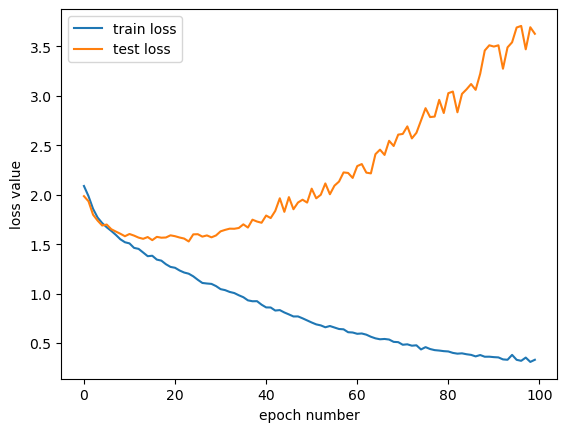

In [14]:
# plot loss
plt.plot(model_1.history["loss"], label = "train loss");
plt.plot(model_1.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

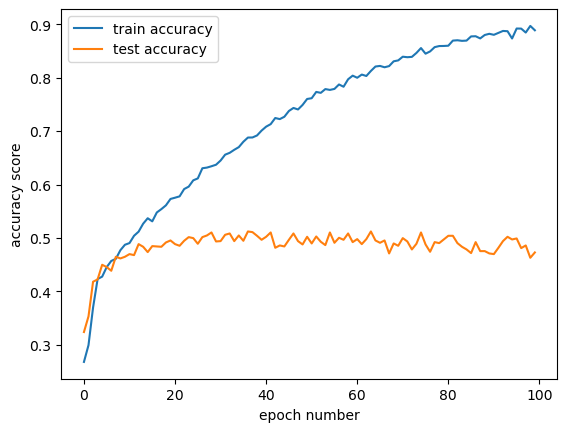

In [15]:
# plot accuracy
plt.plot(model_1.history["accuracy"], label = "train accuracy");
plt.plot(model_1.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

It'll help us to know what's getting mislabeled. Let's do a confusion matrix using the types we've inputted previously.

 1/51 [..............................] - ETA: 7s

2023-03-31 19:50:27.571333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


51/51 [==============================] - 4s 74ms/step


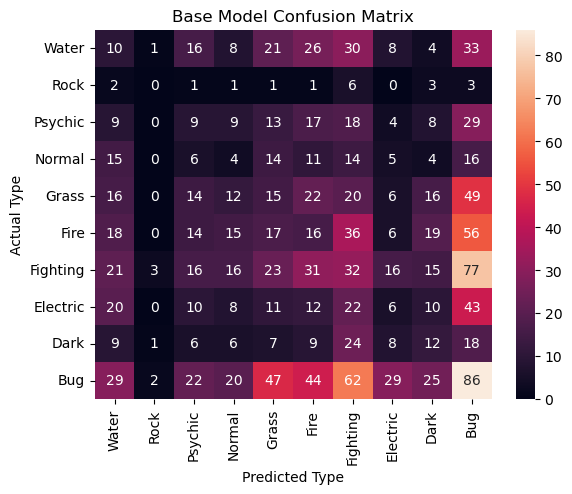

In [16]:
# new labels
types = ["Water", "Rock", "Psychic", "Normal", "Grass", "Fire", "Fighting", "Electric", "Dark", "Bug"]

# get predicted values
Y_pred = model.predict(test_generator, 1534 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

# create confusion matrix
matrix = confusion_matrix(test_generator.classes, y_pred).tolist()

# convert to heatmap
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=types, yticklabels=types)
plt.title('Base Model Confusion Matrix')
plt.xlabel('Predicted Type')
plt.ylabel('Actual Type')
plt.show()

Looks like our Bug type is having the most issue with labeling, both predicted and actual labels. Fighting is also having lots of issues. This makes sense since most of the Pokémon in these types have a mix of colorways, not any set ones.

## Model 2

While train accuracy seems to be going up with each epoch, it looks like test accuracy is holding steady around 53-55% despite the number of epochs. 

We need to solve for overfitting. To do this we can increase regularization, add more convolutional layers, decrease learning rate, and/or change the optimization algorithm from adam to something like SGD.

To begin out iterative process, we'll start by increasing regularization with Dropout and early stopping.

In [17]:
# set Early Stopping for callbacks
es = EarlyStopping(monitor = "val_accuracy", mode = "min", verbose = 1, patience = 30)

In [18]:
# build model
model2 = Sequential()
model2.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(32, 32, 3), kernel_regularizer = reg))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer = reg))
model2.add(Flatten())
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(10, activation='softmax'))
model2.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])
model_2 = model2.fit(train_generator, verbose = 1, validation_data = test_generator, epochs = 100, callbacks=[es])

Epoch 1/100
  1/200 [..............................] - ETA: 56s - loss: 2.3603 - accuracy: 0.1875

2023-03-31 19:50:31.799565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


199/200 [============================>.] - ETA: 0s - loss: 2.1474 - accuracy: 0.2366

2023-03-31 19:50:48.617881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - 21s 106ms/step - loss: 2.1465 - accuracy: 0.2367 - val_loss: 1.9913 - val_accuracy: 0.2879
Epoch 2/100
200/200 [==============================] - 21s 105ms/step - loss: 2.0036 - accuracy: 0.2826 - val_loss: 1.9501 - val_accuracy: 0.2984
Epoch 3/100
200/200 [==============================] - 21s 105ms/step - loss: 1.9660 - accuracy: 0.3169 - val_loss: 1.9297 - val_accuracy: 0.3421
Epoch 4/100
200/200 [==============================] - 21s 106ms/step - loss: 1.9423 - accuracy: 0.3255 - val_loss: 1.9121 - val_accuracy: 0.3452
Epoch 5/100
200/200 [==============================] - 21s 106ms/step - loss: 1.9280 - accuracy: 0.3459 - val_loss: 1.9026 - val_accuracy: 0.3888
Epoch 6/100
200/200 [==============================] - 21s 105ms/step - loss: 1.8840 - accuracy: 0.3655 - val_loss: 1.8466 - val_accuracy: 0.3907
Epoch 7/100
200/200 [==============================] - 21s 104ms/step - loss: 1.8407 - accuracy: 0.3851 - val_loss: 1.8085 - val_accurac

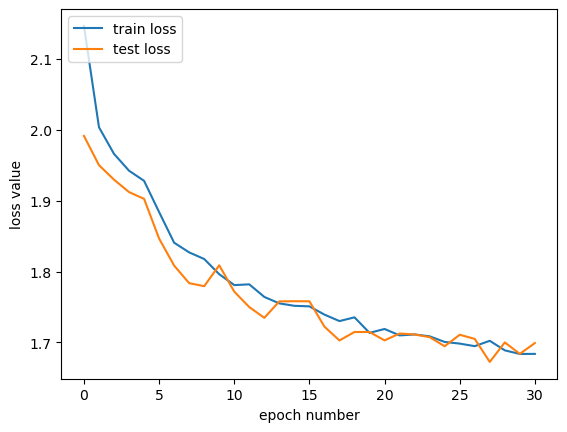

In [19]:
# plot loss
plt.plot(model_2.history["loss"], label = "train loss");
plt.plot(model_2.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

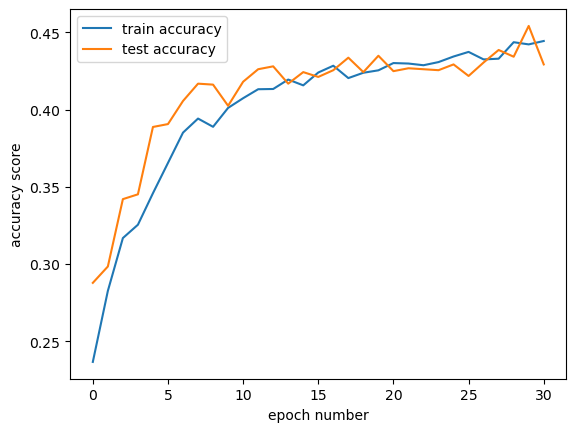

In [20]:
# plot accuracy
plt.plot(model_2.history["accuracy"], label = "train accuracy");
plt.plot(model_2.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

While overfit no longer seems to be an issue, our accuracy is much lower than before. Let's use a confusion matrix to see what the model is getting wrong.

 1/51 [..............................] - ETA: 5s

2023-03-31 20:01:27.496952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


51/51 [==============================] - 4s 77ms/step


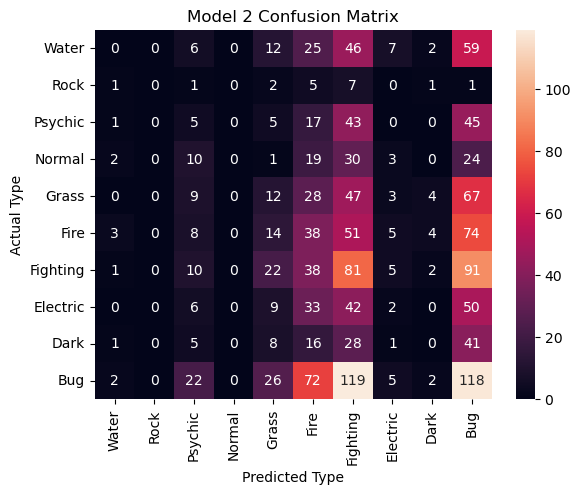

In [21]:
# get predicted values
Y_pred = model2.predict(test_generator, 1534// 32+1)
y_pred = np.argmax(Y_pred, axis=1)

# create confusion matrix
matrix = confusion_matrix(test_generator.classes, y_pred).tolist()

# convert to heatmap
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=types, yticklabels=types)
plt.title('Model 2 Confusion Matrix')
plt.xlabel('Predicted Type')
plt.ylabel('Actual Type')
plt.show()

The type mislabeling is out of control! Everything is now being called a Bug, Grass, or Fighting type despite what it looks like. Not good. Let's go back to Model 1 and try something else.

## Model 3

For Model 3, we're going to use Model 1 again but swap Adam for SGD.

In [22]:
# build model
model3 = Sequential()
model3.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(32, 32, 3), kernel_regularizer = reg))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer = reg))
model3.add(Flatten())
model3.add(Dense(32, activation='relu'))
model3.add(Dense(16, activation='relu'))
model3.add(Dense(10, activation='softmax'))

model3.compile(optimizer='sgd', loss=cce,  metrics=['accuracy'])
model_3 = model3.fit(train_generator, verbose=1, validation_data = test_generator, epochs=50, callbacks=[es])

Epoch 1/50
  1/200 [..............................] - ETA: 46s - loss: 2.3652 - accuracy: 0.2812

2023-03-31 20:01:31.799226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - ETA: 0s - loss: 2.2720 - accuracy: 0.2274

2023-03-31 20:01:49.867208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - 22s 111ms/step - loss: 2.2720 - accuracy: 0.2274 - val_loss: 2.2029 - val_accuracy: 0.2567
Epoch 2/50
200/200 [==============================] - 21s 106ms/step - loss: 2.1850 - accuracy: 0.2666 - val_loss: 2.1251 - val_accuracy: 0.2798
Epoch 3/50
200/200 [==============================] - 21s 106ms/step - loss: 2.1232 - accuracy: 0.2831 - val_loss: 2.1230 - val_accuracy: 0.2953
Epoch 4/50
200/200 [==============================] - 21s 106ms/step - loss: 2.0857 - accuracy: 0.3026 - val_loss: 2.0752 - val_accuracy: 0.3047
Epoch 5/50
200/200 [==============================] - 21s 105ms/step - loss: 2.0614 - accuracy: 0.3063 - val_loss: 2.0345 - val_accuracy: 0.3115
Epoch 6/50
200/200 [==============================] - 21s 106ms/step - loss: 2.0401 - accuracy: 0.3125 - val_loss: 2.0172 - val_accuracy: 0.3551
Epoch 7/50
200/200 [==============================] - 22s 108ms/step - loss: 2.0273 - accuracy: 0.3203 - val_loss: 2.0029 - val_accuracy: 0.3

This doesn't seem to be doing much better than our first model with only a 47% accuracy on the train. We'll have to try something else in the next model.

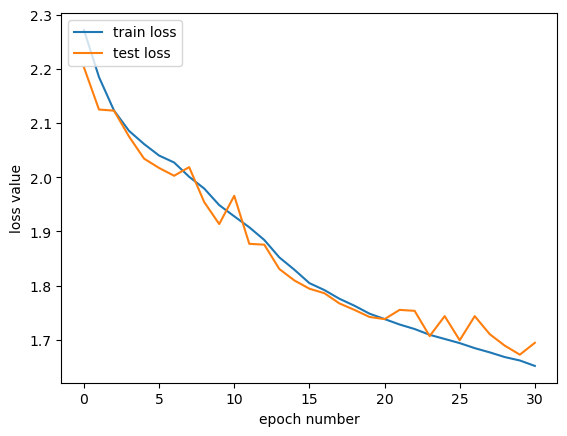

In [23]:
# plot loss
plt.plot(model_3.history["loss"], label = "train loss");
plt.plot(model_3.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

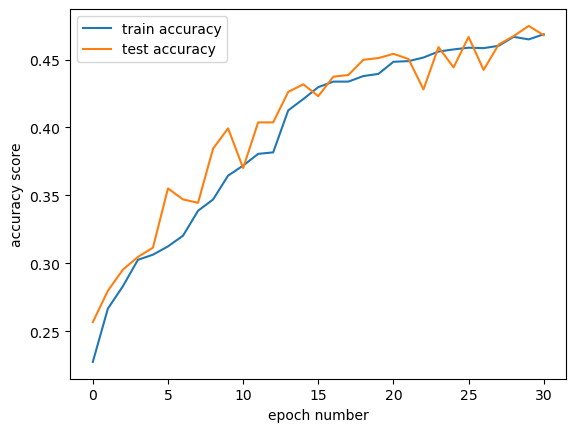

In [24]:
# plot accuracy
plt.plot(model_3.history["accuracy"], label = "train accuracy");
plt.plot(model_3.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

Overfitting seems to be relatively solved at this point, though accuracy on the whole is down again.

 2/51 [>.............................] - ETA: 3s

2023-03-31 20:12:32.166363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


51/51 [==============================] - 4s 76ms/step


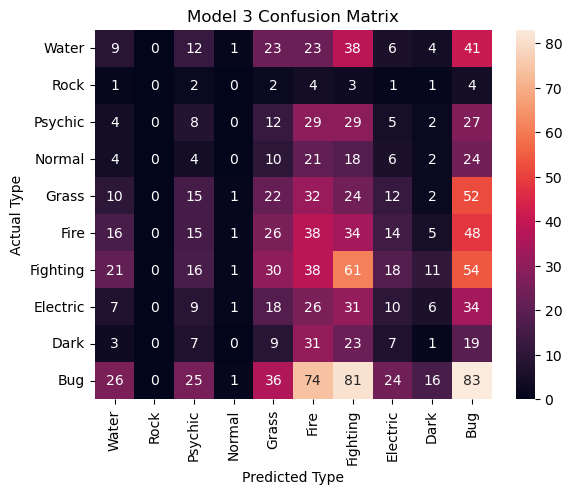

In [25]:
# get predicted values
Y_pred = model3.predict(test_generator, 1534 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

# create confusion matrix
matrix = confusion_matrix(test_generator.classes, y_pred).tolist()

# convert to heatmap
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=types, yticklabels=types)
plt.title('Model 3 Confusion Matrix')
plt.xlabel('Predicted Type')
plt.ylabel('Actual Type')
plt.show()

We're still not seeing an overall trend towards accurate predictions. Rock and Normal type are both missing a lot of labels.

## Model 4

SGD did improve over Model 2 and kept overfit to a minimum. Let's use it again but include more dense layers and see if that improves accuracy.

In [26]:
# build model
model4 = Sequential()
model4.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(32, 32, 3), kernel_regularizer = reg))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer = reg))
model4.add(Flatten())
model4.add(Dense(32, activation='relu'))
model4.add(Dense(32, activation='relu'))
model4.add(Dense(32, activation='relu'))
model4.add(Dense(16, activation='relu'))
model4.add(Dense(16, activation='relu'))
model4.add(Dense(16, activation='relu'))
model4.add(Dense(8, activation='relu'))
model4.add(Dense(10, activation='softmax'))

model4.compile(optimizer='sgd', loss=cce,  metrics=['accuracy'])

model_4 = model4.fit(train_generator, verbose=1, validation_data = test_generator, epochs=100, callbacks = [es])

Epoch 1/100


2023-03-31 20:12:36.437224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - ETA: 0s - loss: 2.3596 - accuracy: 0.1725

2023-03-31 20:12:53.623468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - 22s 107ms/step - loss: 2.3596 - accuracy: 0.1725 - val_loss: 2.3055 - val_accuracy: 0.2280
Epoch 2/100
200/200 [==============================] - 22s 112ms/step - loss: 2.2994 - accuracy: 0.2247 - val_loss: 2.2714 - val_accuracy: 0.2280
Epoch 3/100
200/200 [==============================] - 22s 110ms/step - loss: 2.2727 - accuracy: 0.2247 - val_loss: 2.2517 - val_accuracy: 0.2280
Epoch 4/100
200/200 [==============================] - 22s 108ms/step - loss: 2.2564 - accuracy: 0.2247 - val_loss: 2.2375 - val_accuracy: 0.2280
Epoch 5/100
200/200 [==============================] - 21s 107ms/step - loss: 2.2423 - accuracy: 0.2247 - val_loss: 2.2272 - val_accuracy: 0.2280
Epoch 6/100
200/200 [==============================] - 21s 105ms/step - loss: 2.2256 - accuracy: 0.2247 - val_loss: 2.2031 - val_accuracy: 0.2280
Epoch 7/100
200/200 [==============================] - 21s 106ms/step - loss: 2.2045 - accuracy: 0.2247 - val_loss: 2.1890 - val_accurac

Too bad! Only a 40% accuracy on the test. Overall worse than the last model.

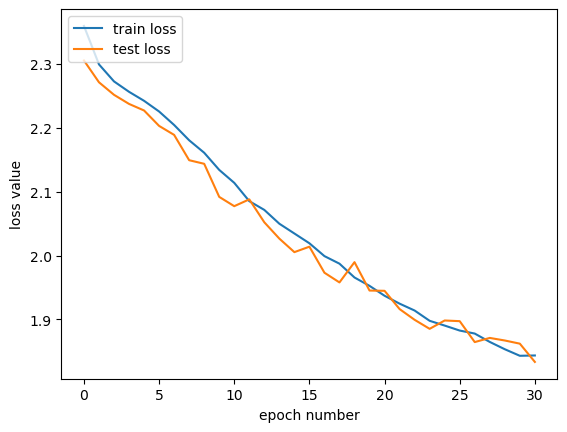

In [27]:
# plot loss
plt.plot(model_4.history["loss"], label = "train loss");
plt.plot(model_4.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

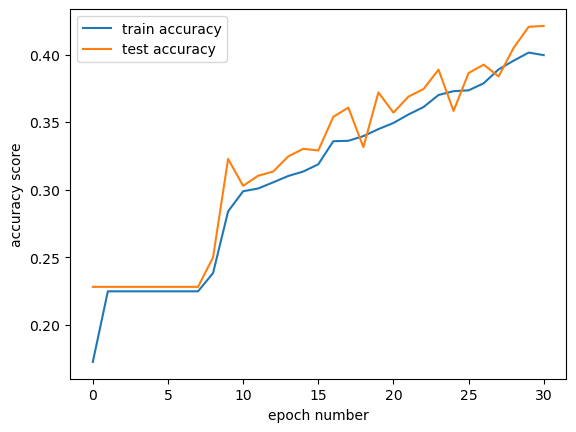

In [28]:
# plot accuracy
plt.plot(model_4.history["accuracy"], label = "train accuracy");
plt.plot(model_4.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

 2/51 [>.............................] - ETA: 3s

2023-03-31 20:23:30.792443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


51/51 [==============================] - 4s 75ms/step


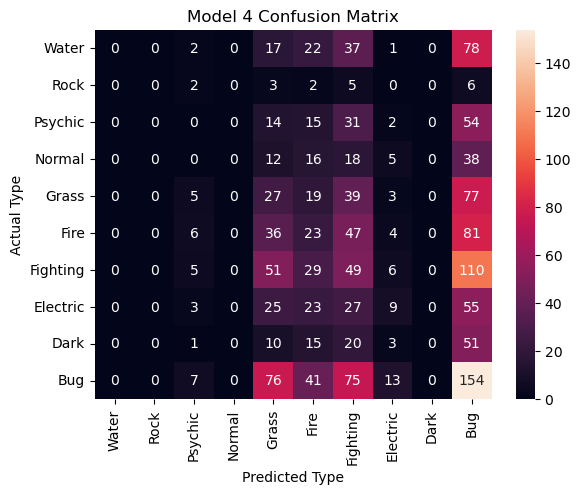

In [29]:
# get predicted values
Y_pred = model4.predict(test_generator, 1534 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

# create confusion matrix
matrix = confusion_matrix(test_generator.classes, y_pred).tolist()

# convert to heatmap
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=types, yticklabels=types)
plt.title('Model 4 Confusion Matrix')
plt.xlabel('Predicted Type')
plt.ylabel('Actual Type')
plt.show()

Again, we're missing labels but this time for even more types including Water, Pyschic, and Dark types.

Adding more layers didn't seem to solve much. The last thing we can try is changing the learning rate.

## Model 5

This time we have a higher learning rate and a few more convolutional layers. At this point we're throwing a lot at the model to see if we can scale up from 50% accuracy of the first model, which is still the best one.

In [30]:
# build model
opt = SGD(lr = 0.1)

model5 = Sequential()
model5.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = (32, 32, 3)))
model5.add(MaxPooling2D(pool_size = (2, 2)))
model5.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer = reg))
model5.add(MaxPooling2D((2,2)))
model5.add(Dense(128, activation= 'relu'))
model5.add(Dropout(.3))
model5.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer = reg))
model5.add(MaxPooling2D((2,2)))
model5.add(Flatten())
model5.add(Dense(32, activation = 'relu'))
model5.add(Dense(16, activation ='relu'))
model5.add(Dense(10, activation = 'softmax'))

model5.compile(optimizer = opt, loss = cce,  metrics = ['accuracy'])
model_5 = model5.fit(train_generator, verbose=1, validation_data = test_generator, epochs = 50, callbacks = [es])

Epoch 1/50


2023-03-31 20:23:35.085996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - ETA: 0s - loss: 2.4624 - accuracy: 0.2221

2023-03-31 20:23:52.220296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - 21s 106ms/step - loss: 2.4624 - accuracy: 0.2221 - val_loss: 2.4465 - val_accuracy: 0.2293
Epoch 2/50
200/200 [==============================] - 21s 104ms/step - loss: 2.2741 - accuracy: 0.2691 - val_loss: 2.1888 - val_accuracy: 0.3178
Epoch 3/50
200/200 [==============================] - 21s 104ms/step - loss: 2.1611 - accuracy: 0.3126 - val_loss: 2.1191 - val_accuracy: 0.3514
Epoch 4/50
200/200 [==============================] - 21s 104ms/step - loss: 2.0993 - accuracy: 0.3241 - val_loss: 2.0311 - val_accuracy: 0.3595
Epoch 5/50
200/200 [==============================] - 21s 105ms/step - loss: 2.0691 - accuracy: 0.3252 - val_loss: 2.2934 - val_accuracy: 0.2393
Epoch 6/50
200/200 [==============================] - 21s 104ms/step - loss: 2.0347 - accuracy: 0.3321 - val_loss: 2.0249 - val_accuracy: 0.3146
Epoch 7/50
200/200 [==============================] - 21s 105ms/step - loss: 1.9496 - accuracy: 0.3608 - val_loss: 1.8527 - val_accuracy: 0.4

This model unfortunately still can't surpass our simplest one, the first one. With only a 50% accuracy it isn't good enough to continue with.

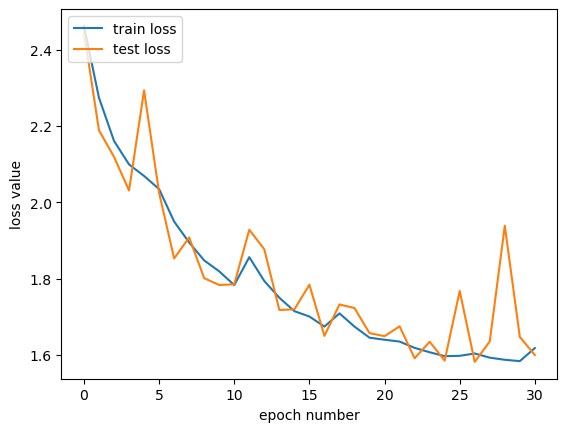

In [31]:
# plot loss
plt.plot(model_5.history["loss"], label = "train loss");
plt.plot(model_5.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

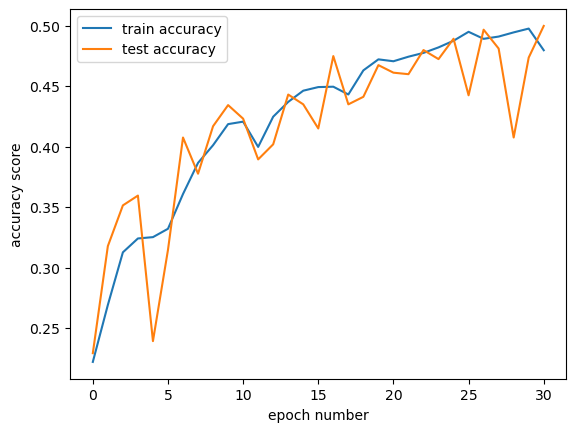

In [32]:
# plot accuracy
plt.plot(model_5.history["accuracy"], label = "train accuracy");
plt.plot(model_5.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

 3/51 [>.............................] - ETA: 2s

2023-03-31 20:34:25.371602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


51/51 [==============================] - 4s 75ms/step


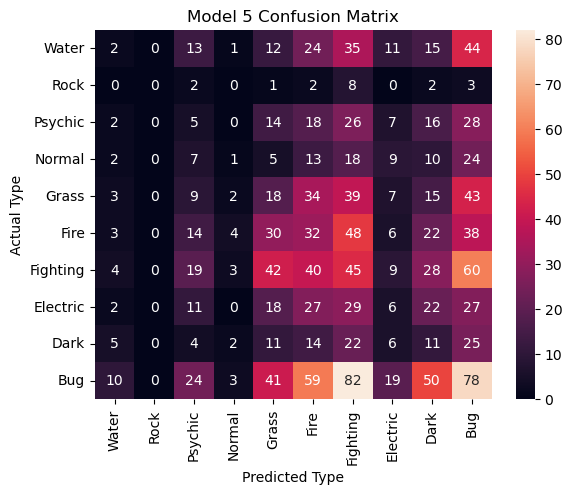

In [33]:
# get predicted values
Y_pred = model5.predict(test_generator, 1534 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

# create confusion matrix
matrix = confusion_matrix(test_generator.classes, y_pred).tolist()

# convert to heatmap
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=types, yticklabels=types)
plt.title('Model 5 Confusion Matrix')
plt.xlabel('Predicted Type')
plt.ylabel('Actual Type')
plt.show()

It seems like with more layers, the model is defaulting to labeling almost everything as Bug or Fighting types.

Of the five models we tried, Model 1 is the best with two convolutional layers and two dense ones.

# Conclusion
The models demonstrate that the appearance of a Pokémon is not a good enough indicator of typing. It's hard to determine the type of a Pokémon based just on how it looks. This comes down to design and a lack of images.

## Recommendations
My recommendations, after modeling, are that the Pokémon company should consider matching their Pokémon designs more so to typing to help future game players (mostly kids) learn about the world quickly and effectively. Also, the lack of images for the later generations had much to do with the lack of these Pokémon being present in marketing products and the show. This should be changed.


## Next Steps
Next steps would be to collect more images and a greater diversity of them, paying special attention to the Pokémon that are underrepresented in the dataset. Also, bringing in all the types and secondary typing is critical to the next Pokédex.